In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from numpy.random import default_rng
from graph.structure.graph import Graph
from graph.prior import SparsePrior
from graph.propagator import UnitaryPropagator
from graph.measurement import GaussianMeasurement
from core.linalg_utils import random_unitary_matrix, random_binary_mask
from core.metrics import mse

# 1. パラメータ設定
n = 1024
rho = 0.1          # sparsity
var = 1e-4         # noise variance
mask_ratio = 0.3  # percentage of observed entries

# 2. ユニタリ行列 U の生成
rng = default_rng(seed=12)
U = random_unitary_matrix(n, rng=rng)
mask = random_binary_mask(n, subsampling_rate=mask_ratio, rng = rng)

# 3. グラフ構築
class CompressiveSensingGraph(Graph):
    def __init__(self):
        super().__init__()
        x = ~SparsePrior(rho=rho, shape=(n,), damping = 0.03, label = "x", dtype = np.complex128)
        y = UnitaryPropagator(U) @ x
        self.meas = GaussianMeasurement(var=var, mask=mask) @ y
        self.compile()

g = CompressiveSensingGraph()

# 4. RNG設定（初期メッセージとサンプリングを分離）
g.set_init_rng(np.random.default_rng(seed=11))
g.generate_sample(rng=np.random.default_rng(seed=42))

# 5. 真の信号と観測データを取得
true_x = g.get_wave("x").get_sample()

# 6. 推論の実行
def monitor(graph, t):
    x = graph.get_wave("x")
    est = x.compute_belief().data
    err = mse(est, true_x)
    if t % 5 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

g.run(n_iter=30, callback=monitor)

# 8. 最終精度を表示
final_est = g.get_wave("x").compute_belief().data
print(f"Final MSE after 30 iterations: {mse(final_est, true_x):.5e}")

BP Iteration: 100%|██████████| 30/30 [00:00<00:00, 825.01it/s]

[t=0] MSE = 4.19261e-01
[t=5] MSE = 5.42152e-03
[t=10] MSE = 5.22805e-05
[t=15] MSE = 4.33186e-05
[t=20] MSE = 4.37273e-05
[t=25] MSE = 4.37302e-05
Final MSE after 30 iterations: 4.37304e-05


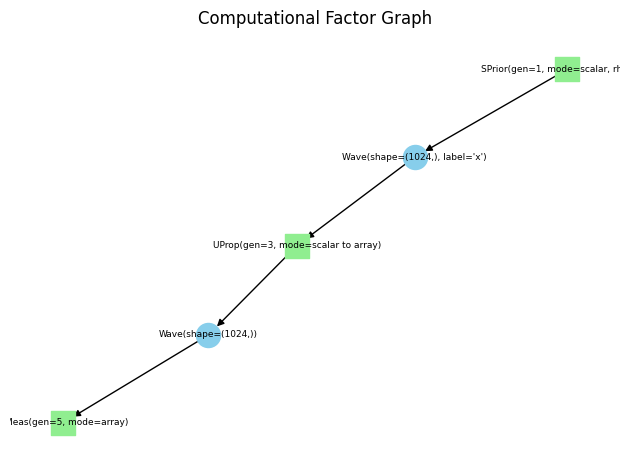

In [3]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

### Profiling

In [4]:
%prun -l 40  g.run(n_iter=30, callback=None, verbose = None)

         6766 function calls (6756 primitive calls) in 0.037 seconds

   Ordered by: internal time
   List reduced from 65 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       30    0.028    0.001    0.029    0.001 unitary_propagator.py:74(compute_belief)
       30    0.002    0.000    0.003    0.000 sparse_prior.py:47(approximate_posterior)
       90    0.001    0.000    0.002    0.000 uncertain_array.py:332(__truediv__)
       60    0.001    0.000    0.002    0.000 linalg_utils.py:4(reduce_precision_to_scalar)
      120    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
      270    0.000    0.000    0.001    0.000 uncertain_array.py:58(__init__)
       30    0.000    0.000    0.000    0.000 uncertain_array.py:365(damp_with)
      540    0.000    0.000    0.001    0.000 numeric.py:1855(isscalar)
       60    0.000    0.000    0.001    0.000 _methods.py:101(_mean)
      270    0.000    0.000    0.000 